In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("mitanshuchakrawarty/new-idd-dataset")
print("Path to dataset files:", path)

100%|██████████| 2.79G/2.79G [00:32<00:00, 93.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1


In [ ]:
print(path)

/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1


In [ ]:
import kagglehub

# Download latest version
path2 = kagglehub.dataset_download("gauravsrc/iitbhu-roads-dataset")

print("Path to dataset files:", path2)

100%|██████████| 137M/137M [00:00<00:00, 242MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gauravsrc/iitbhu-roads-dataset/versions/1


In [ ]:
n = len(os.listdir(path+'/IDD_RESIZED/image_archive'))
print(n)

6993


In [ ]:
filenames = sorted(os.listdir(path2+'/1/'))
for i in range(0,len(filenames), 2):
    Image.open(path2+'/1/'+filenames[i]).save(path+'/IDD_RESIZED/image_archive/'+'Image_'+str(n)+'.png')
    Image.open(path2+'/1/'+filenames[i+1]).save(path+'/IDD_RESIZED/mask_archive/'+'Mask_'+str(n)+'.png')
    n+=1

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [ ]:

def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Get sorted file lists, ensure images and masks are paired correctly
image_dir = path+'/IDD_RESIZED/image_archive/'
mask_dir = path+'/IDD_RESIZED/mask_archive/'

image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

# Convert lists to TensorFlow tensors
image_ds = tf.data.Dataset.from_tensor_slices(image_files)
mask_ds = tf.data.Dataset.from_tensor_slices(mask_files)

# Zip together to create (image, mask) pairs
dataset = tf.data.Dataset.zip((image_ds, mask_ds))


In [ ]:
image_files[:5]

['/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1/IDD_RESIZED/image_archive/Image_0.png',
 '/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1/IDD_RESIZED/image_archive/Image_1.png',
 '/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1/IDD_RESIZED/image_archive/Image_10.png',
 '/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1/IDD_RESIZED/image_archive/Image_100.png',
 '/root/.cache/kagglehub/datasets/mitanshuchakrawarty/new-idd-dataset/versions/1/IDD_RESIZED/image_archive/Image_1000.png']

In [ ]:
IMG_SIZE = 128
N_CHANNELS = 3
def load_image_and_mask(image_path, mask_path):
    # Read and decode the image

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # One channel for mask
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.cast(mask, tf.uint8)
    return image, mask

In [ ]:
dataset= dataset.map(load_image_and_mask)
dataset = dataset.batch(32)

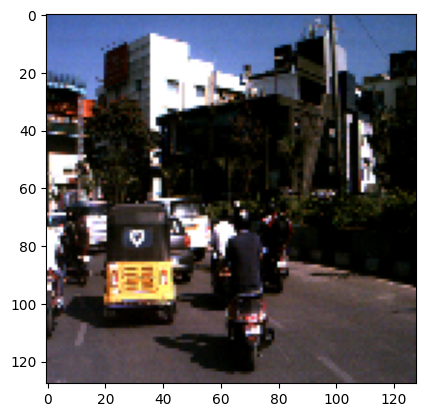

In [ ]:
for img, mask in dataset.take(1):
    # plt.subplots(1,1,figsize=(10,10))
    plt.imshow(img[1])
    # plt.subplots(1,2,figsize=(10,10))
    # plt.imshow(mask[1],cmap='grey')
    # print(mask[1])
plt.show()

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
inputs = Input(input_shape)
N_CLASSES = 1
# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")


In [ ]:
outputs

<KerasTensor shape=(None, 128, 128, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_64>

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.round(pred_mask)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

In [ ]:
history = model.fit(dataset, epochs=30)

Epoch 1/30


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 128, 128, 1), output.shape=(None, 4, 4, 1)

In [ ]:
model.save('model.keras')

tf.Tensor(
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]], shape=(128, 128, 1), dtype=uint8)


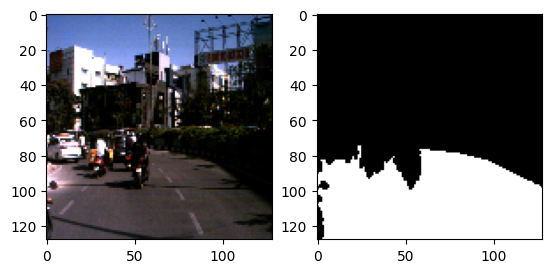

In [ ]:
def create_mask(pred_mask: tf.Tensor):
    # Round to closest
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])

for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
    plt.subplot(1,2,1)
    plt.imshow(sample_image[0])
    plt.subplot(1,2,2)
    print(sample_mask[0])
    plt.imshow(sample_mask[0], cmap='grey')
    plt.show()
# show_predictions()

In [ ]:
import cv2


In [ ]:
def weighted_img(mask, img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(img, α, mask, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)

    # Convert to image image
    image = np.asarray(image, np.float32)

    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset.take(1):
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            print(image.shape)
            p = model.predict(tf.expand_dims(image, axis = 0))
            final_image = process_image_mask(image, p[0])
            save_sample([image, final_image], index)
            index += 1

Processing image : 0
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


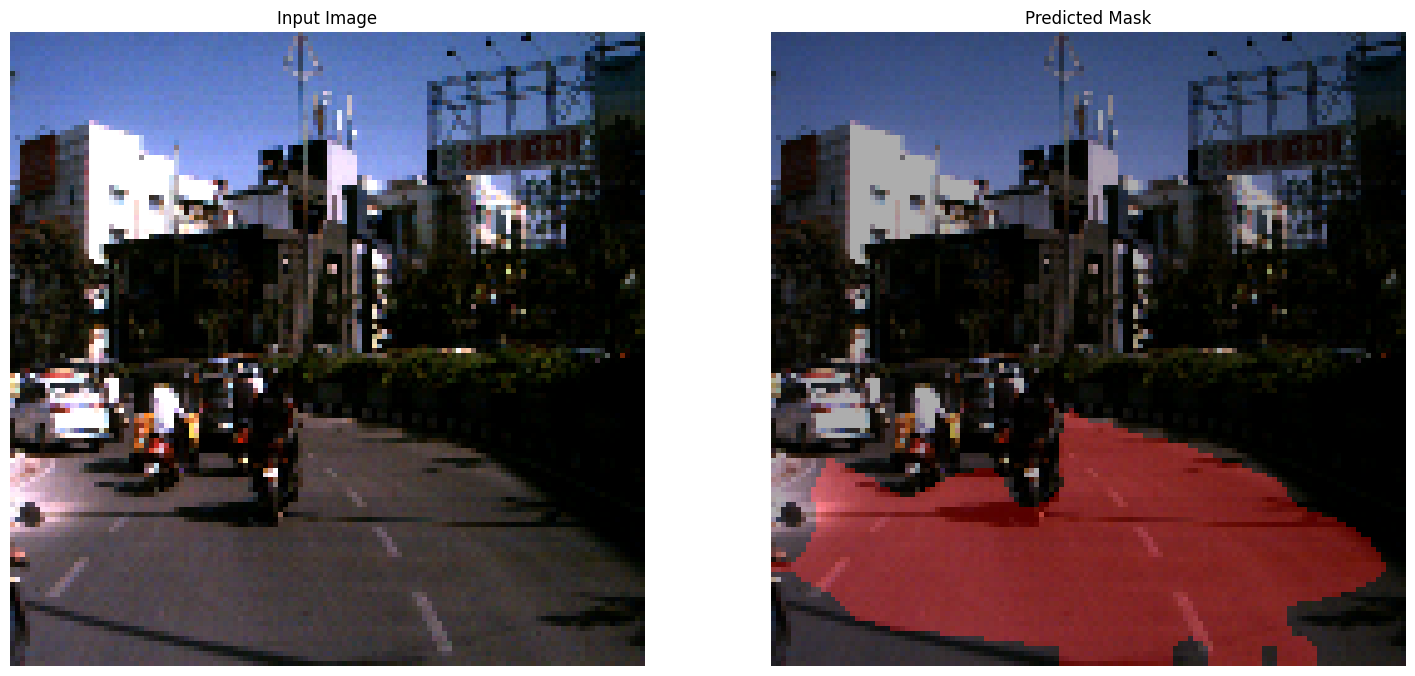

Processing image : 1
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


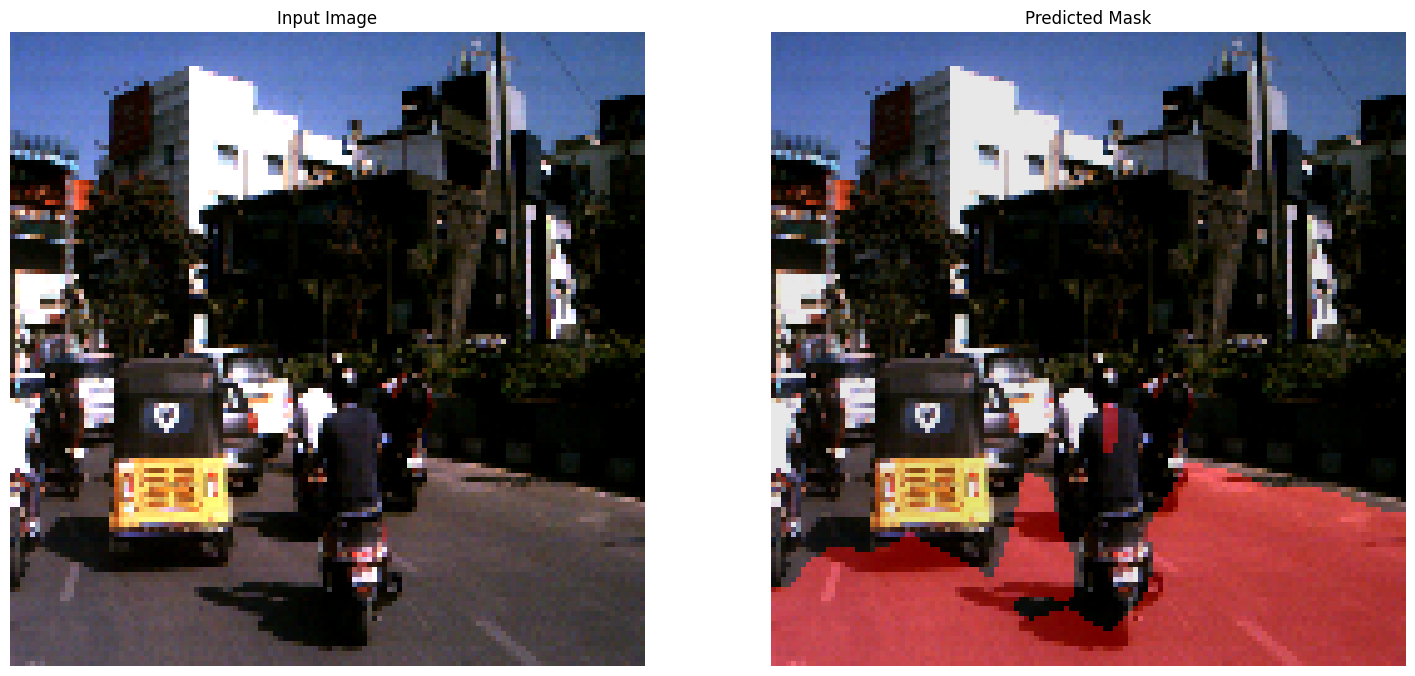

Processing image : 2
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


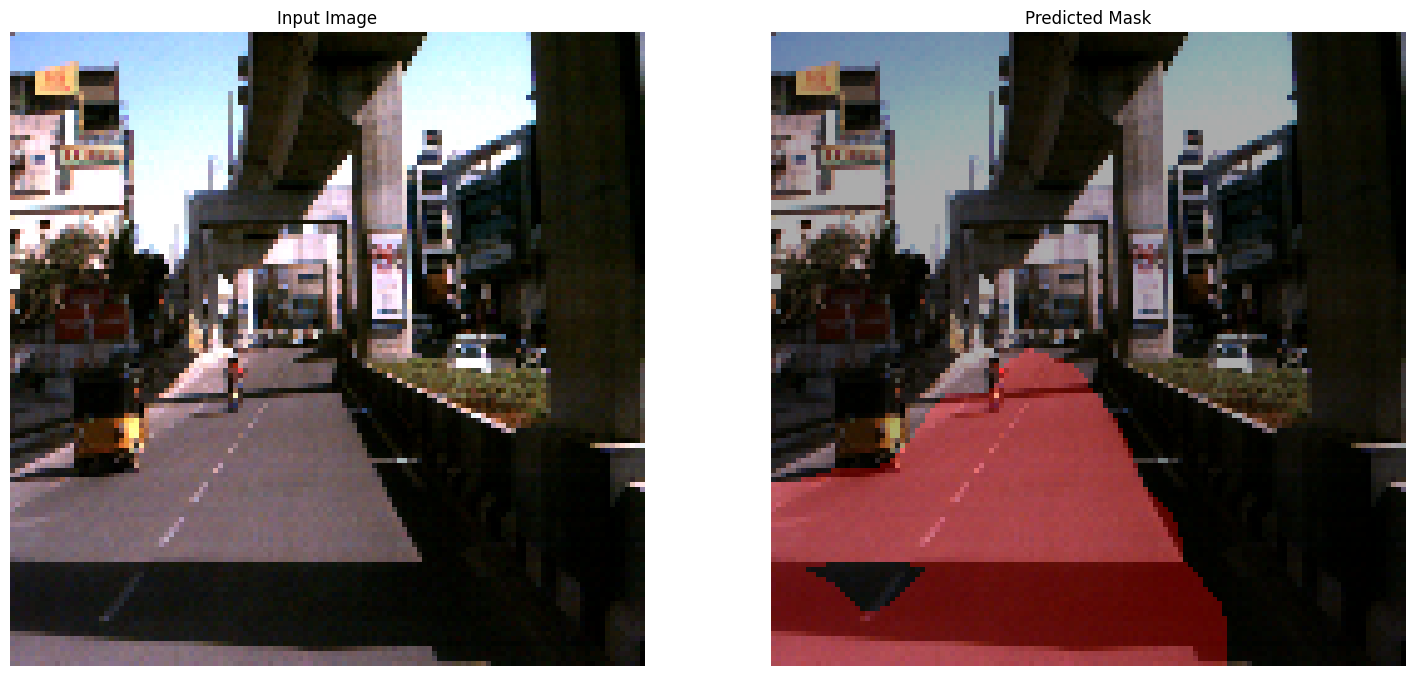

Processing image : 3
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


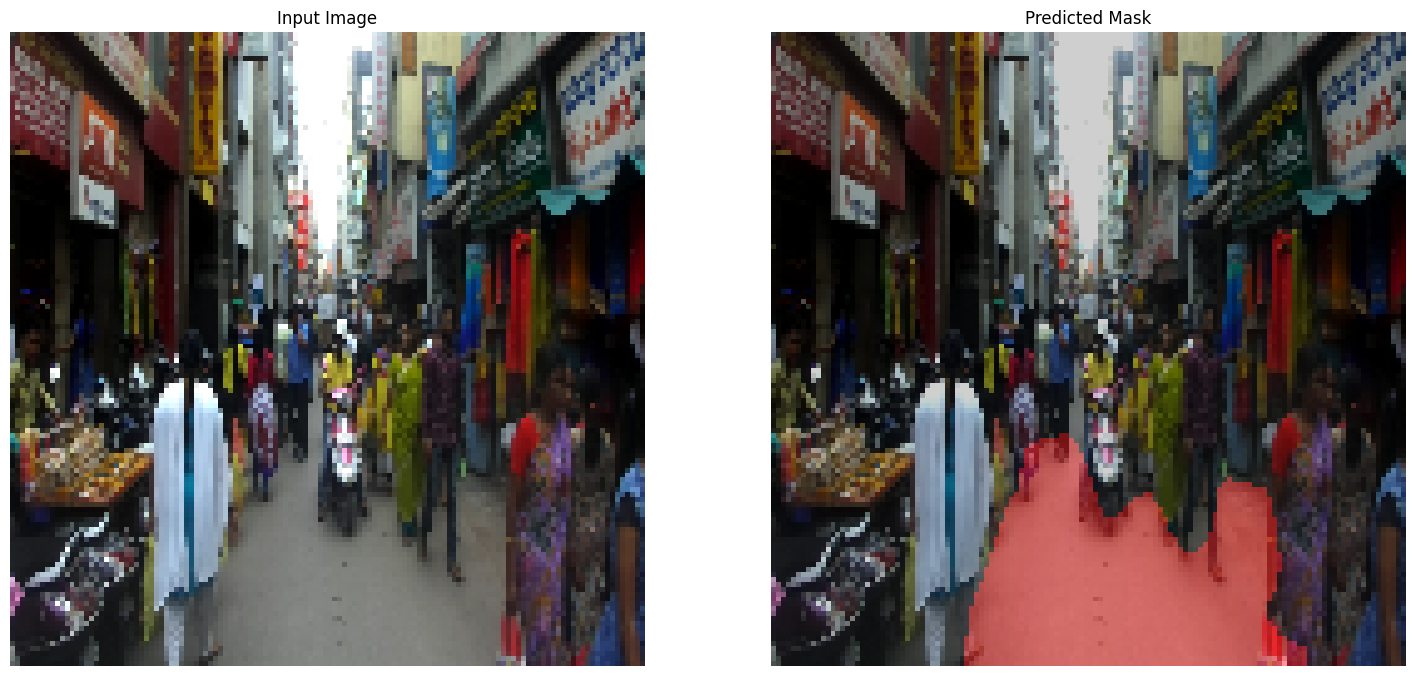

Processing image : 4
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


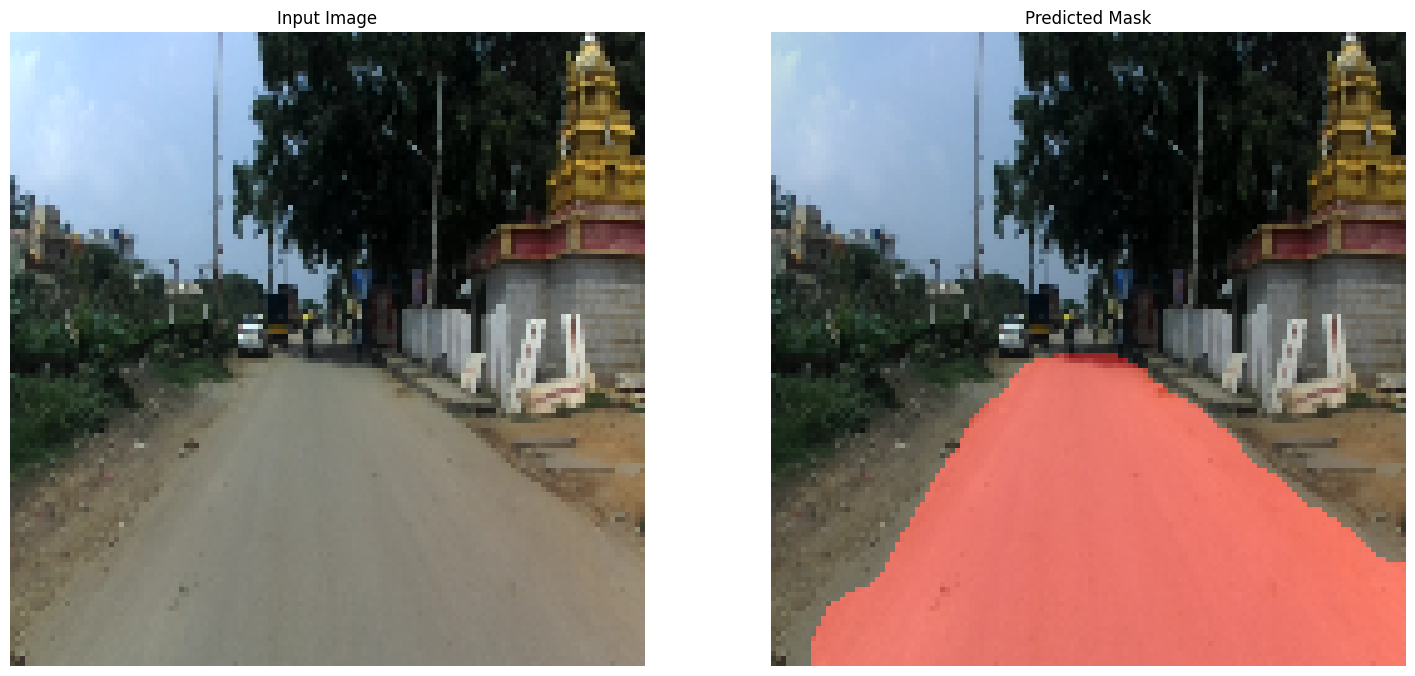

Processing image : 5
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


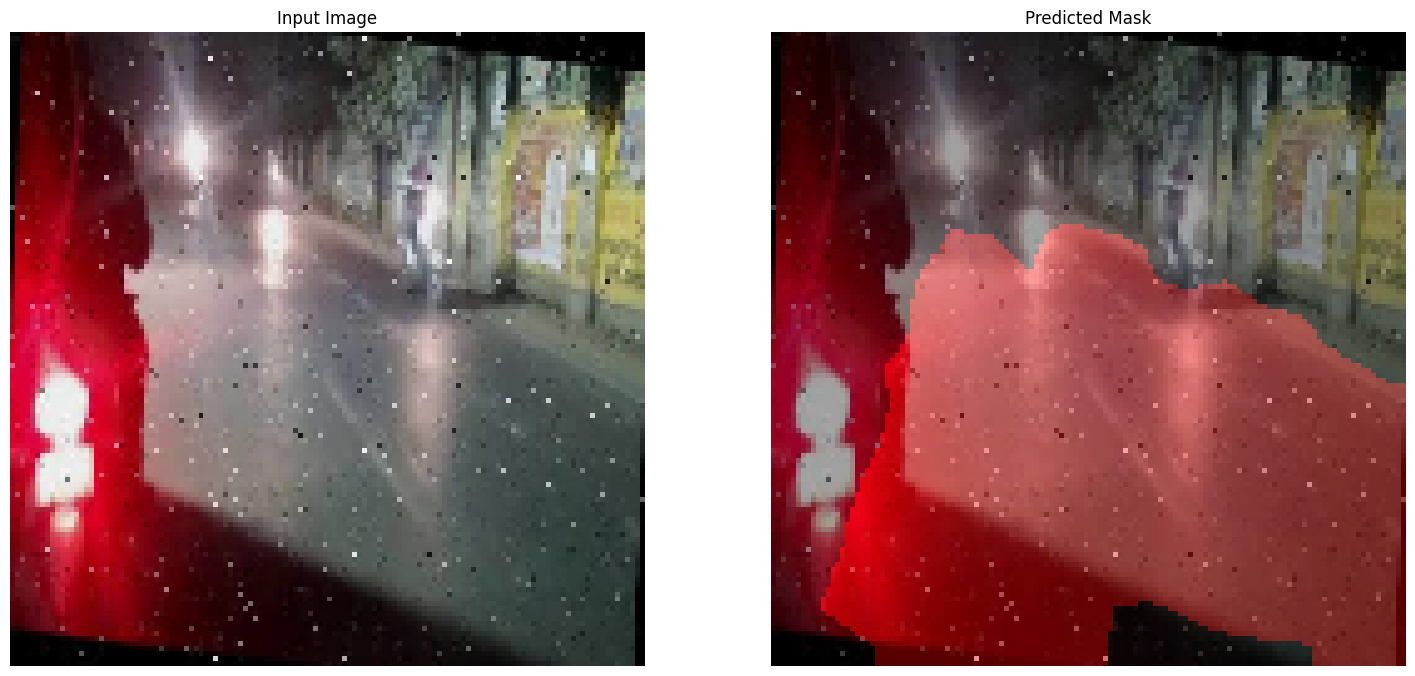

Processing image : 6
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


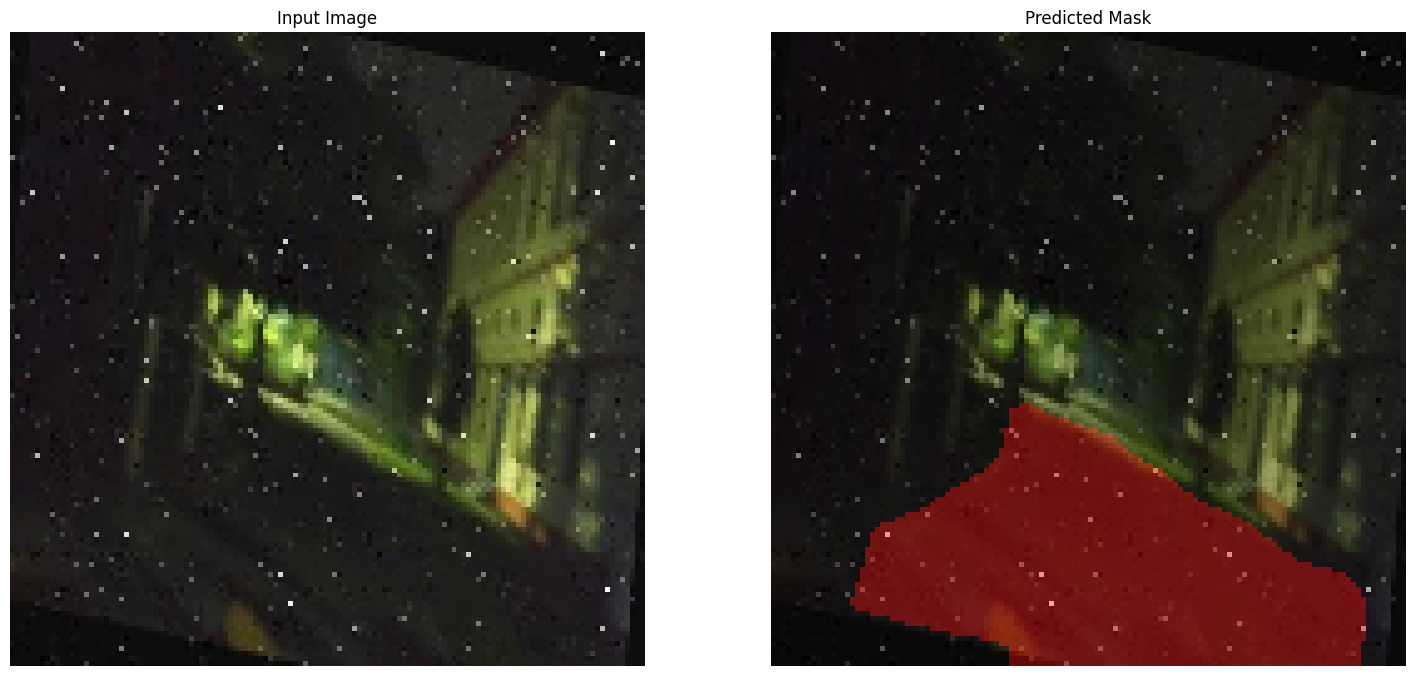

Processing image : 7
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


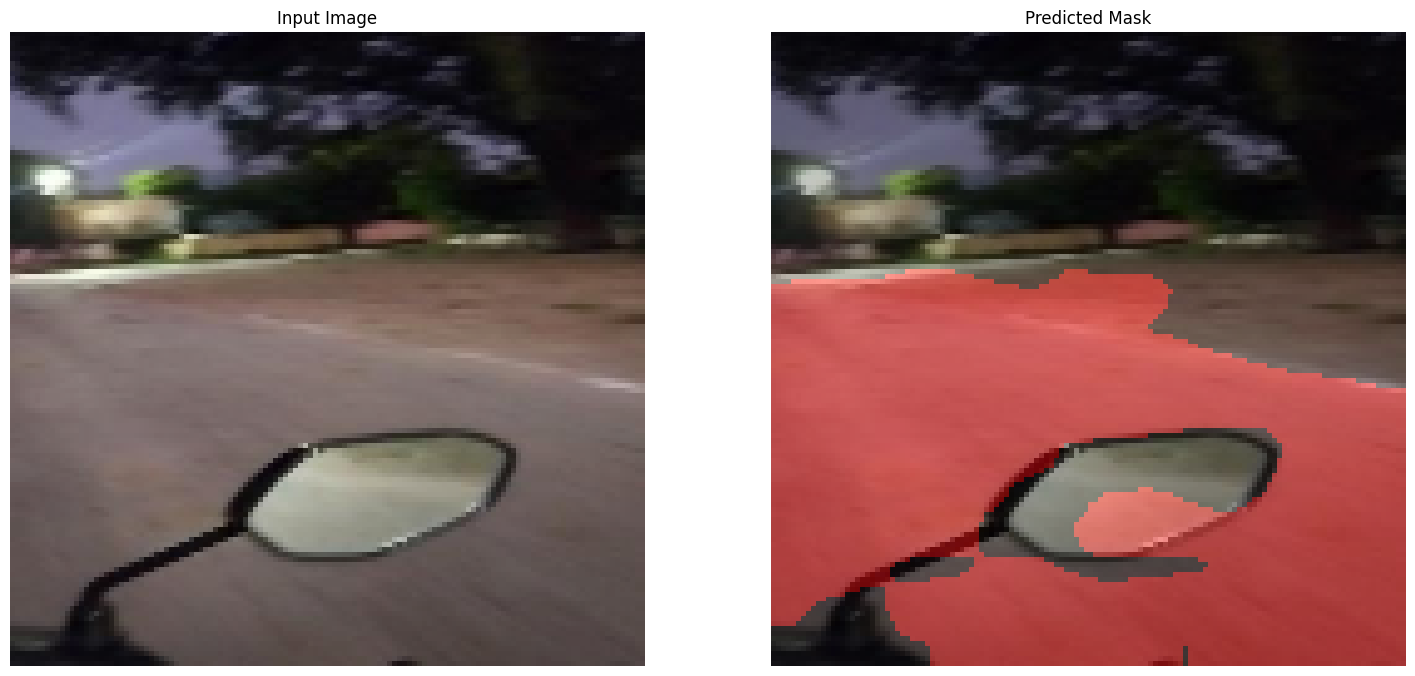

Processing image : 8
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


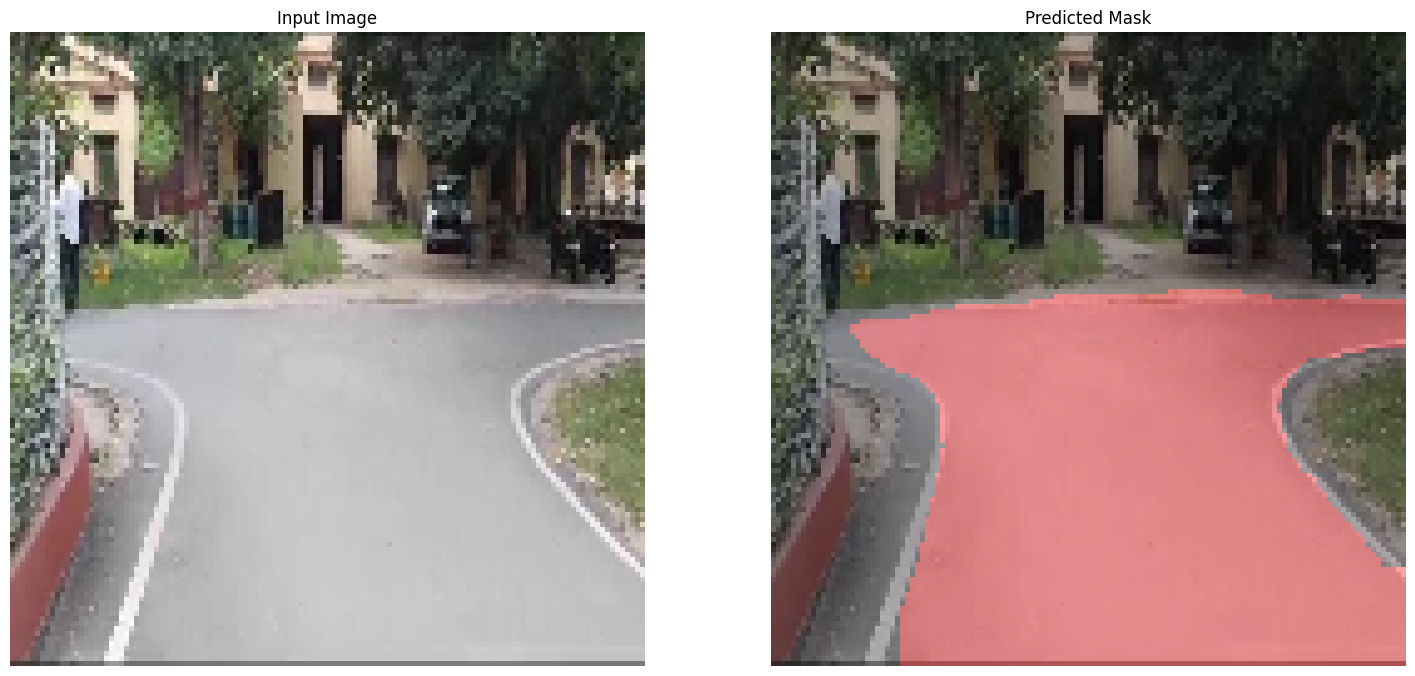

Processing image : 9
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


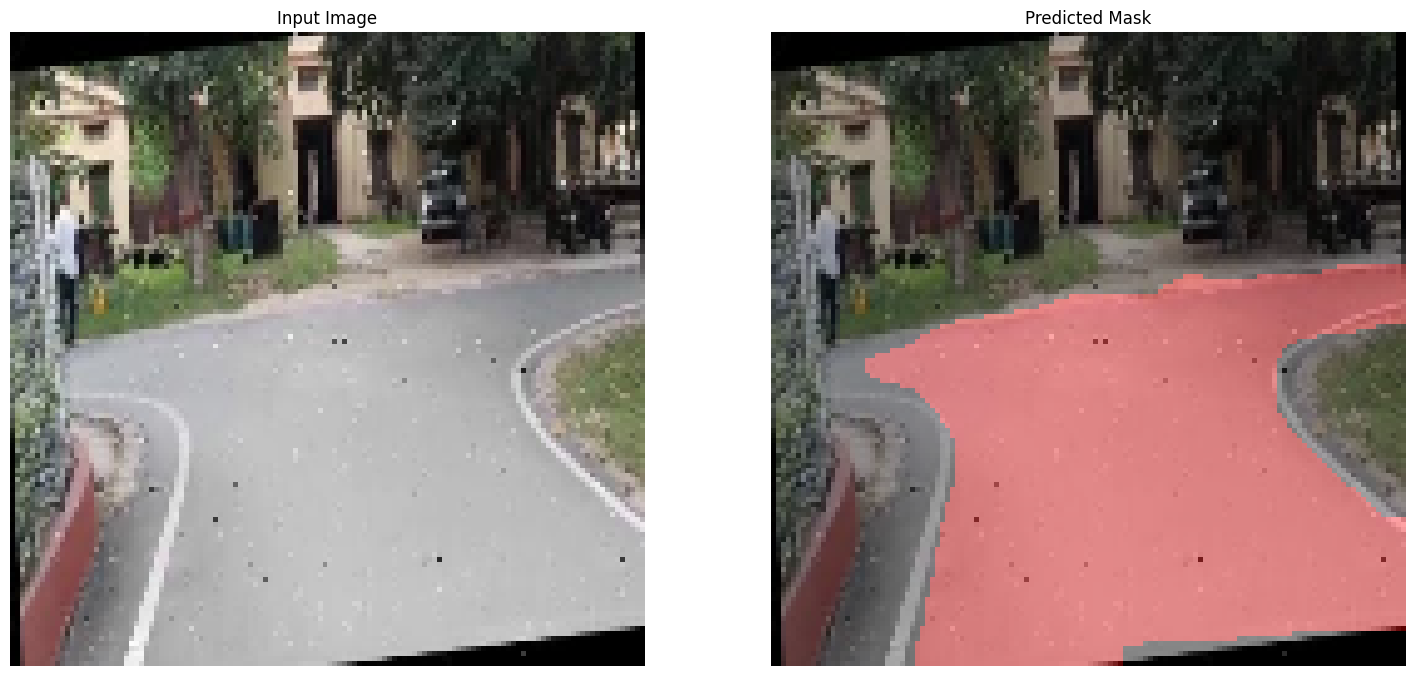

Processing image : 10
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


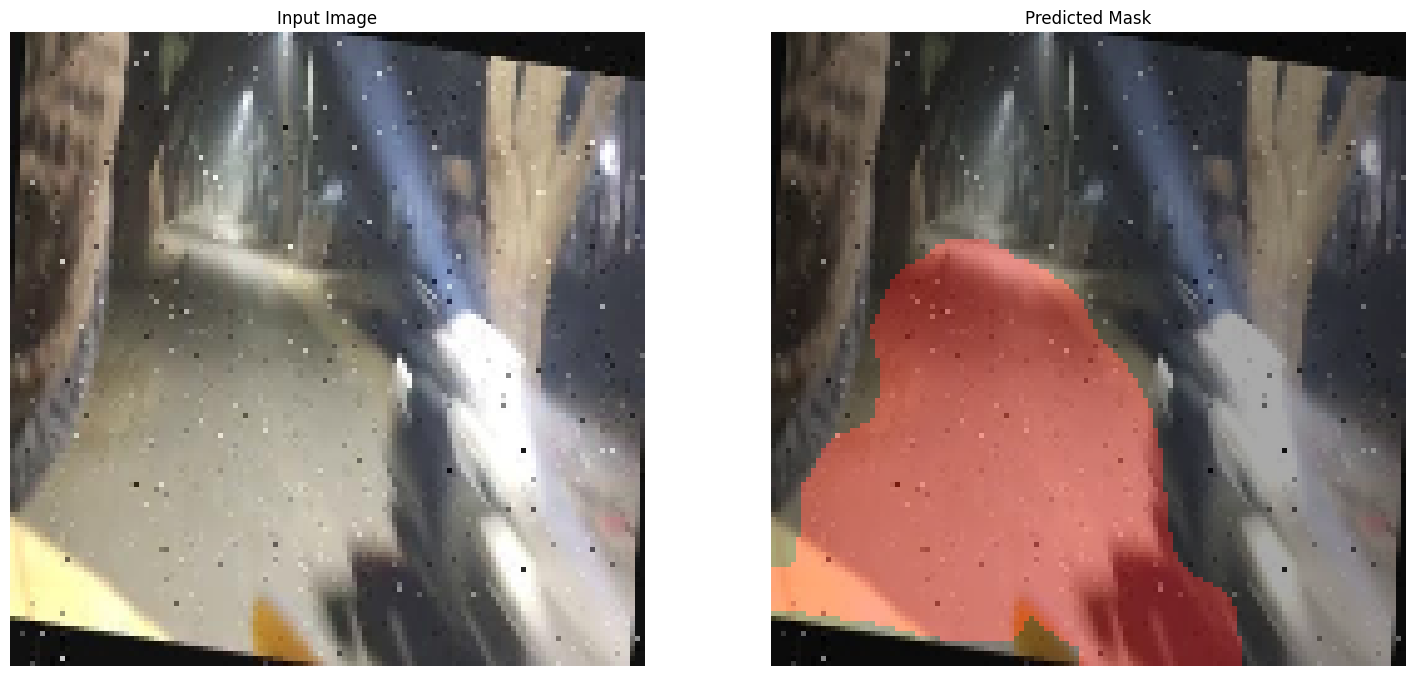

Processing image : 11
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


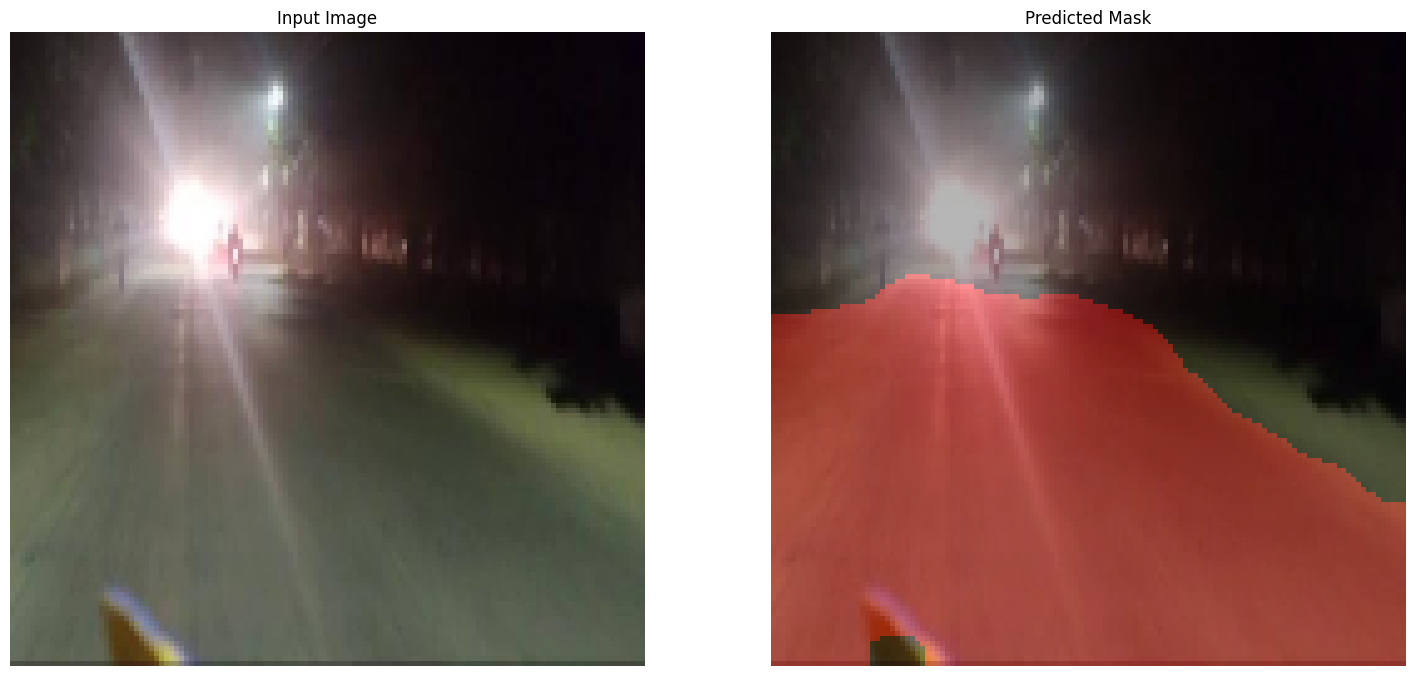

Processing image : 12
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


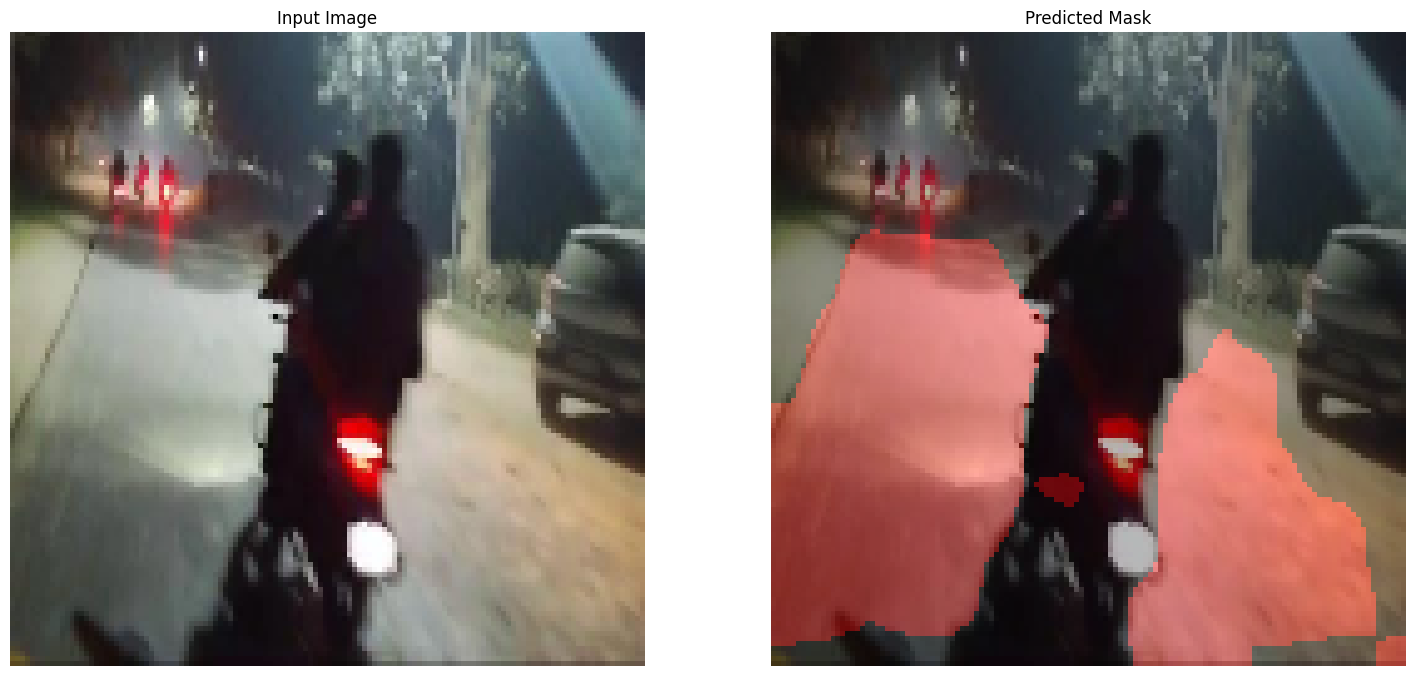

Processing image : 13
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


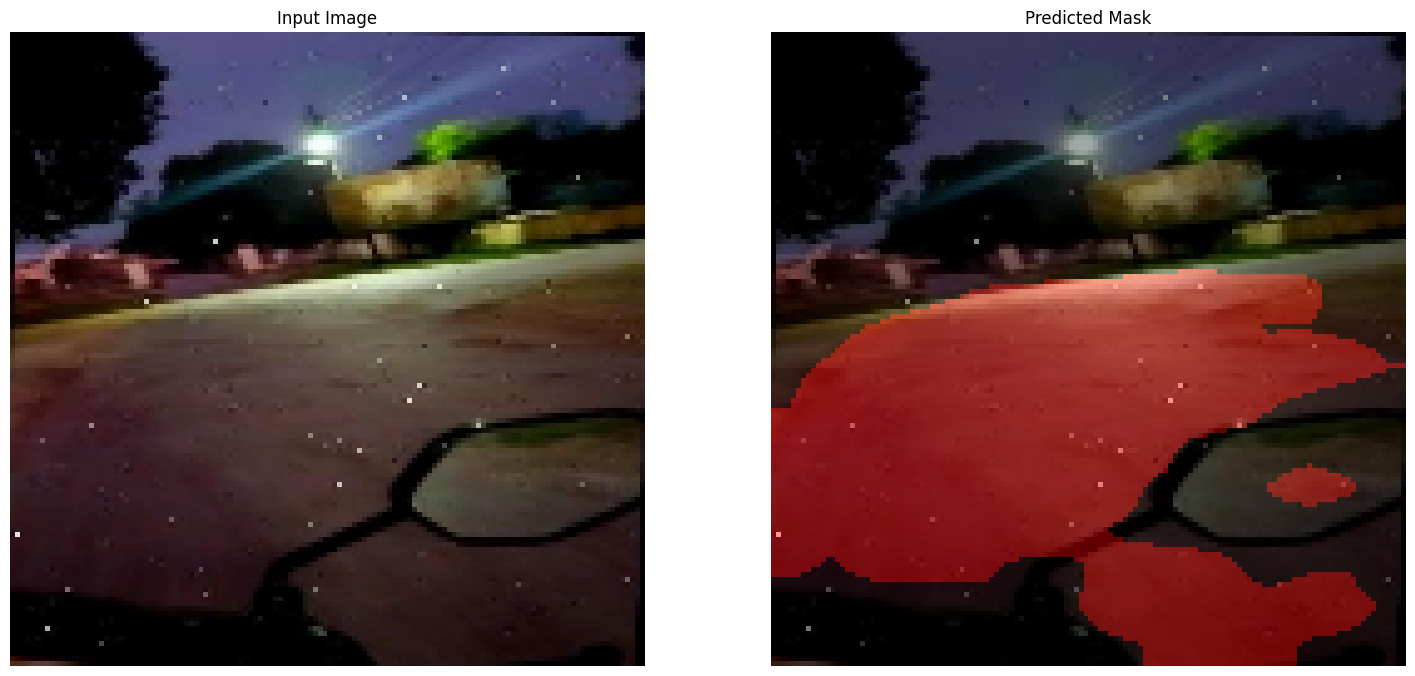

Processing image : 14
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


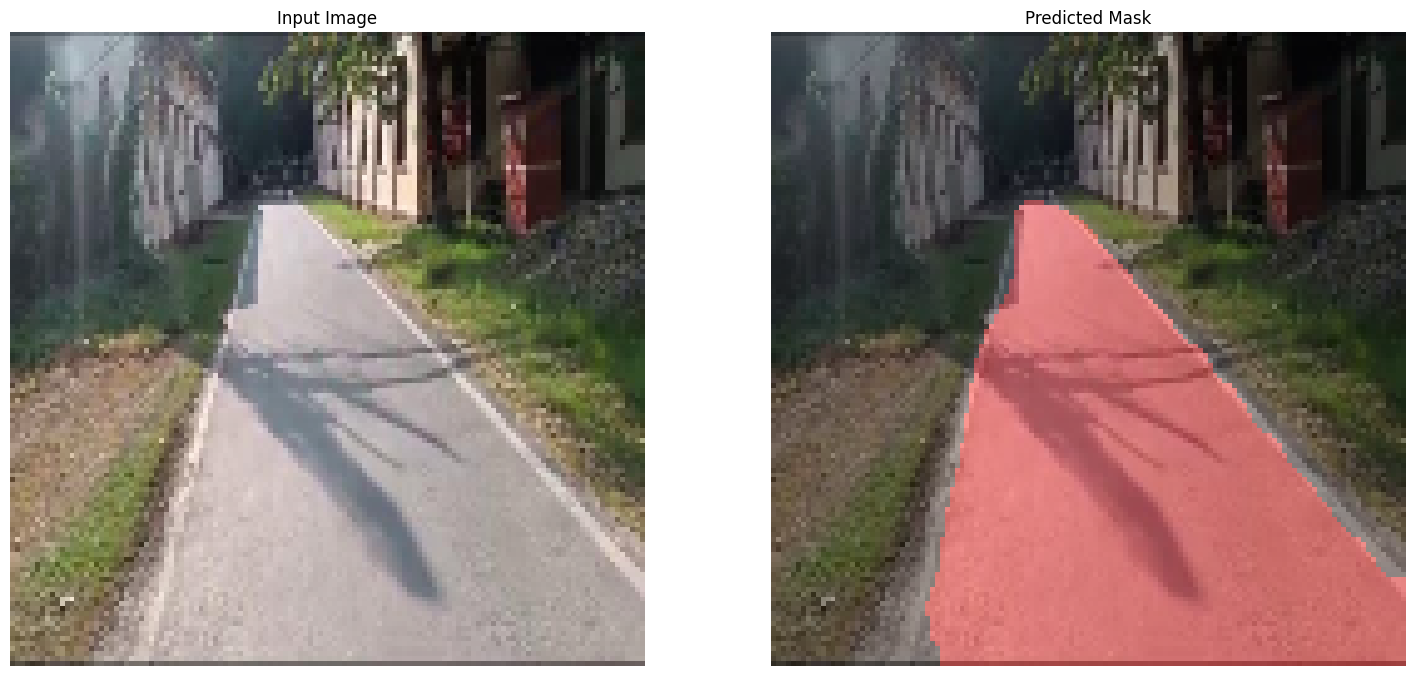

Processing image : 15
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


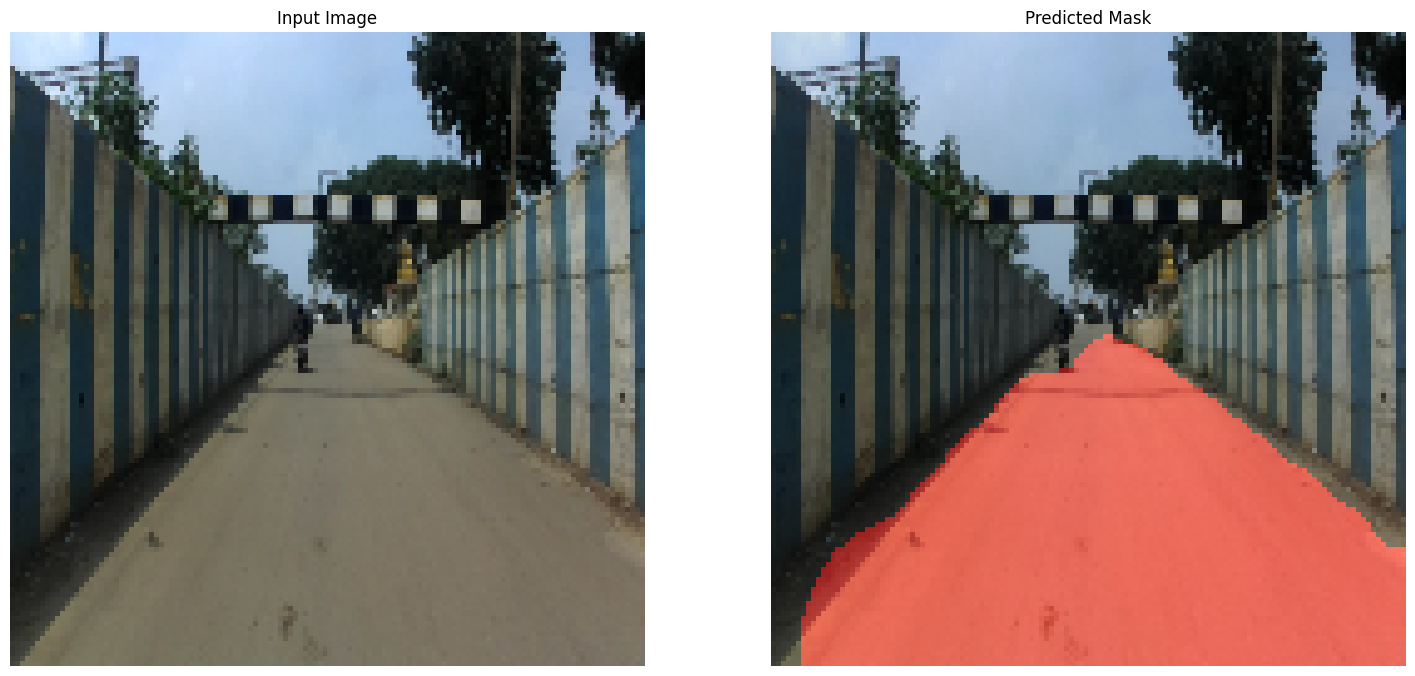

Processing image : 16
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


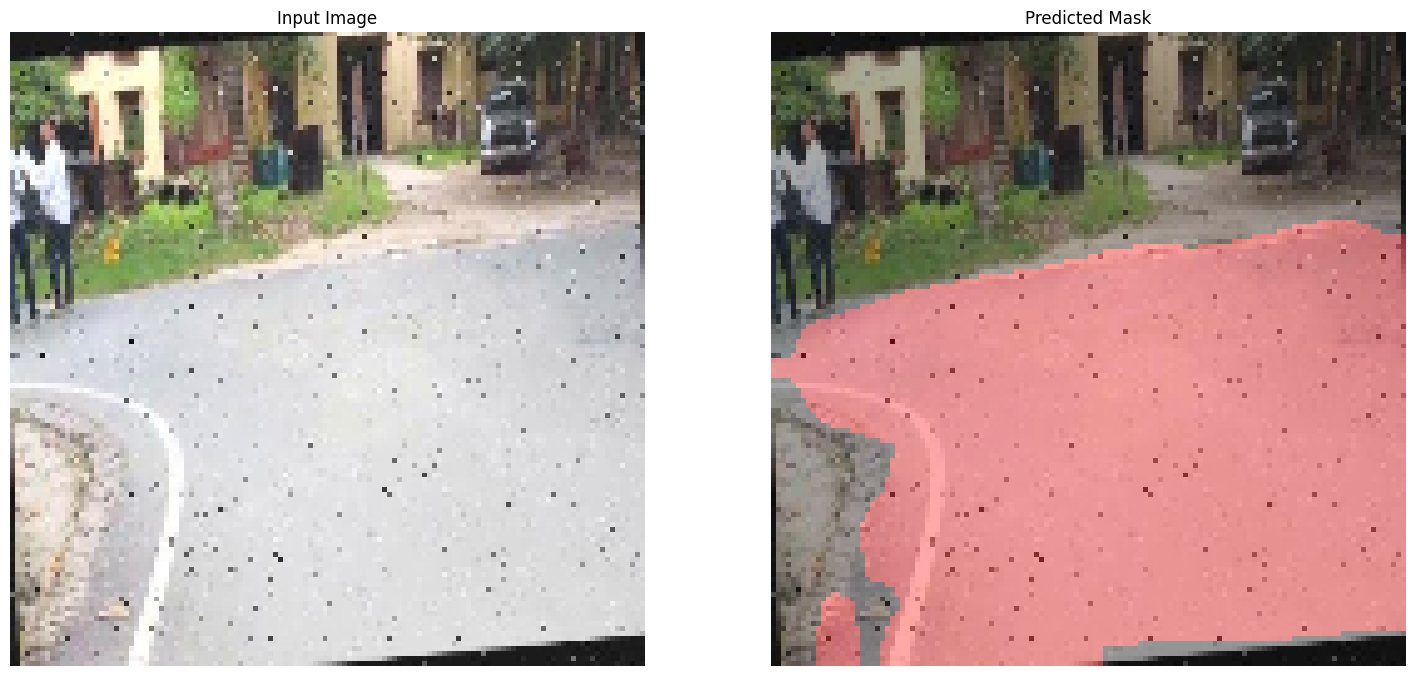

Processing image : 17
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


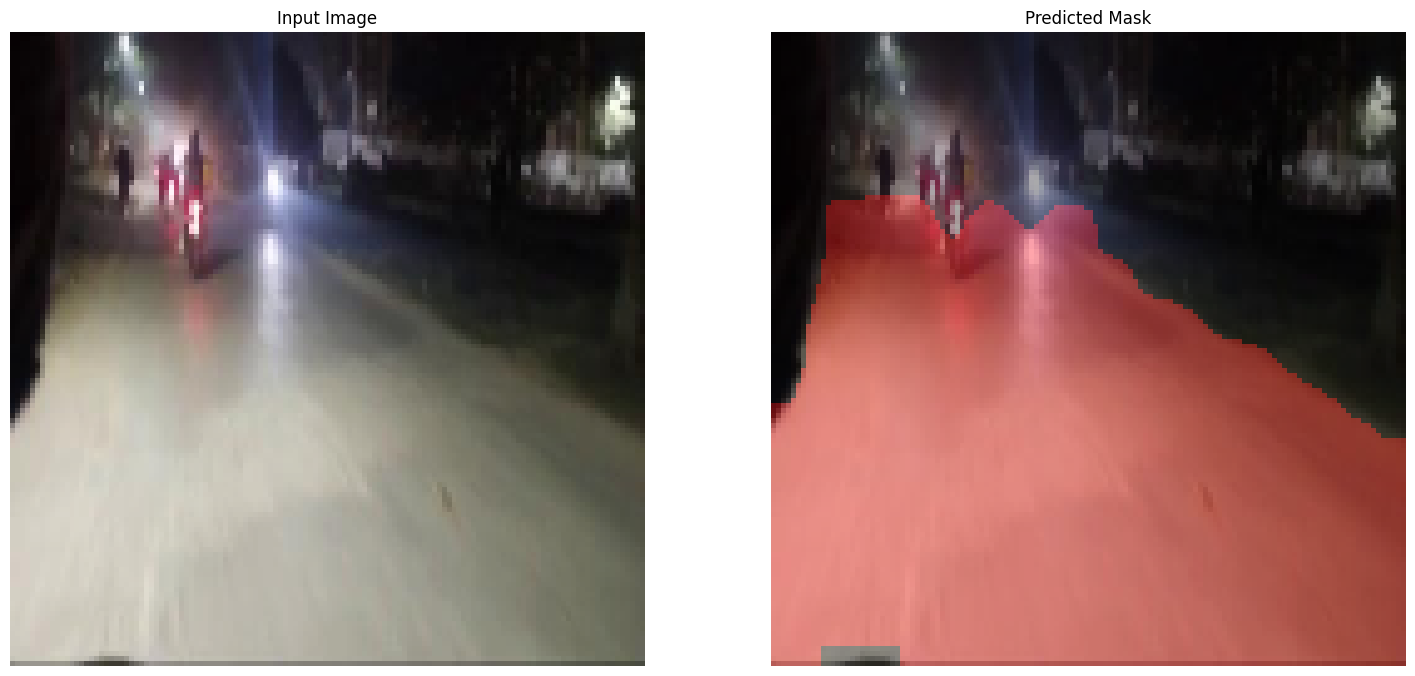

Processing image : 18
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


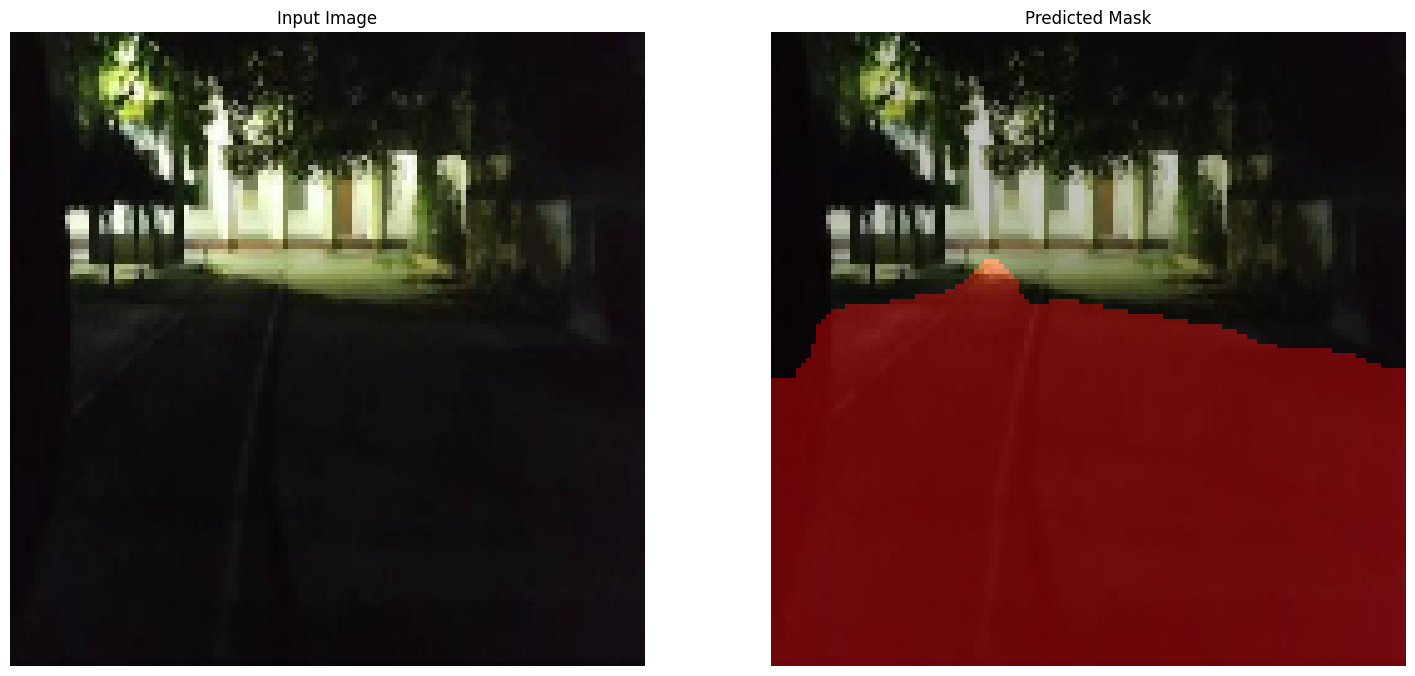

Processing image : 19
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


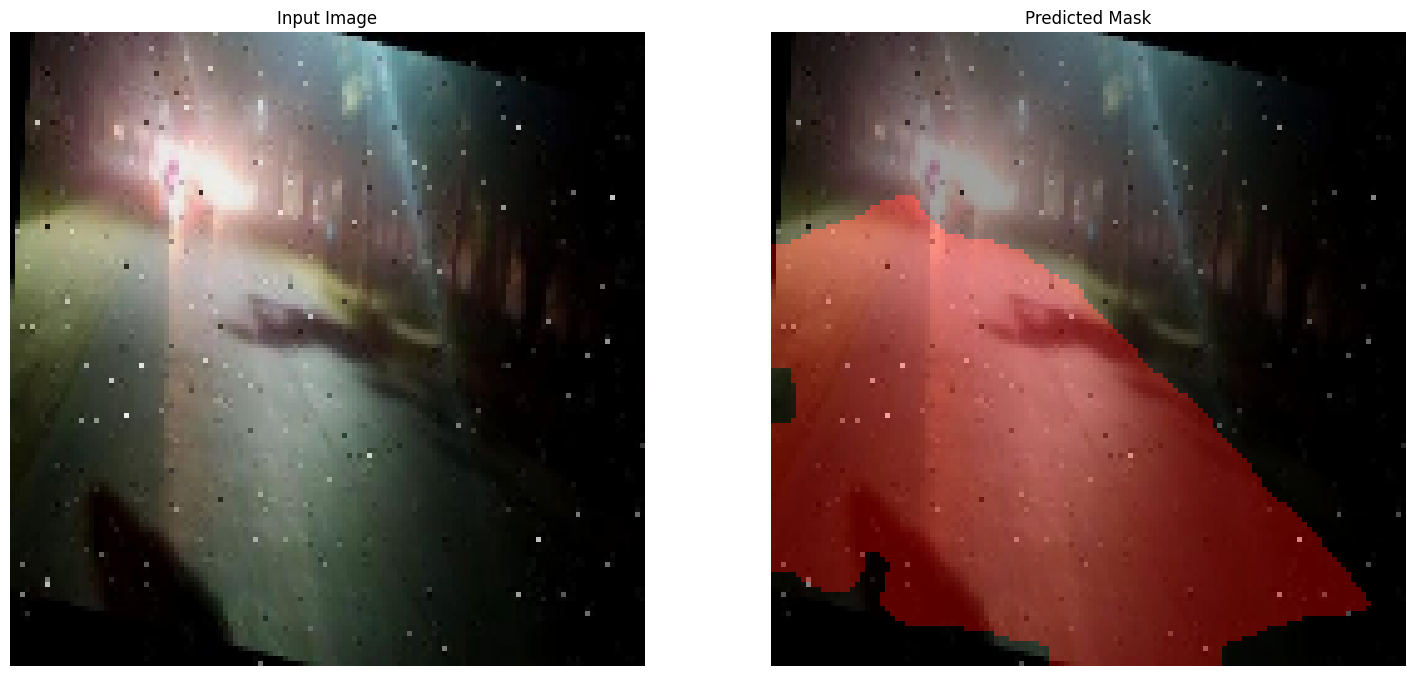

Processing image : 20
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


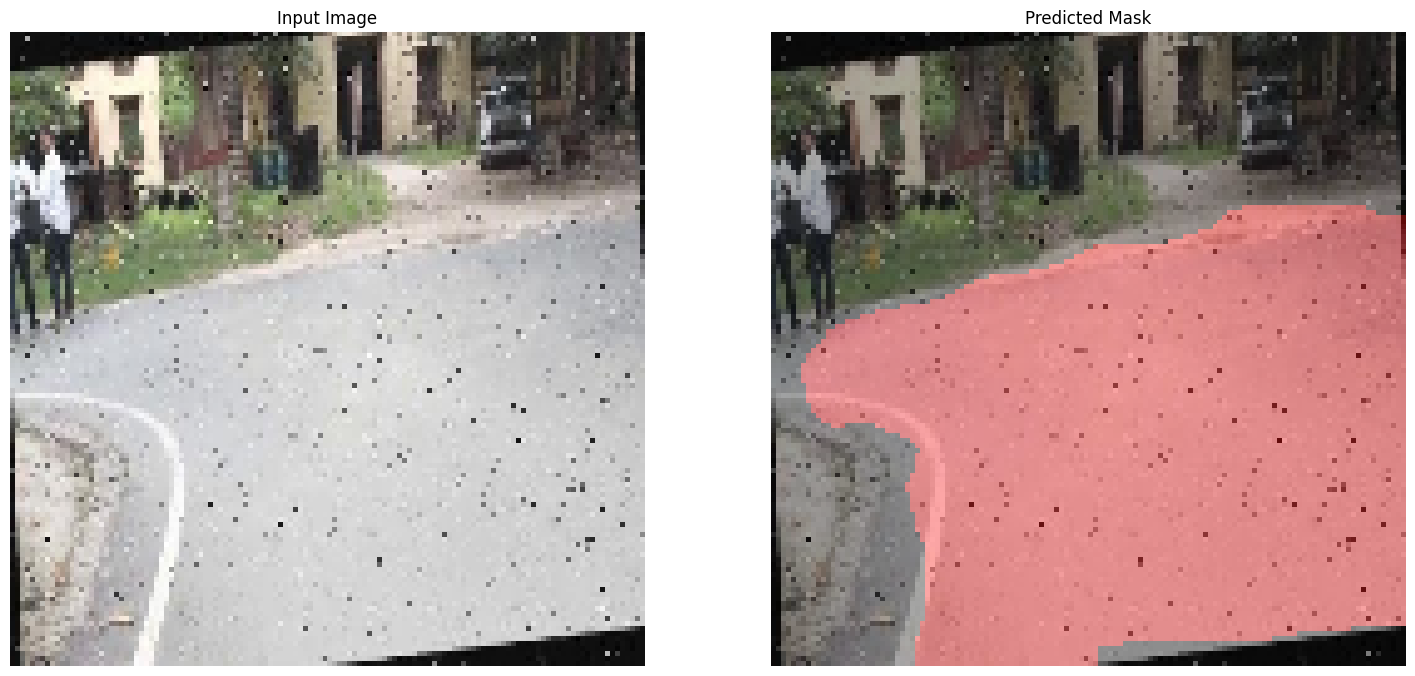

Processing image : 21
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


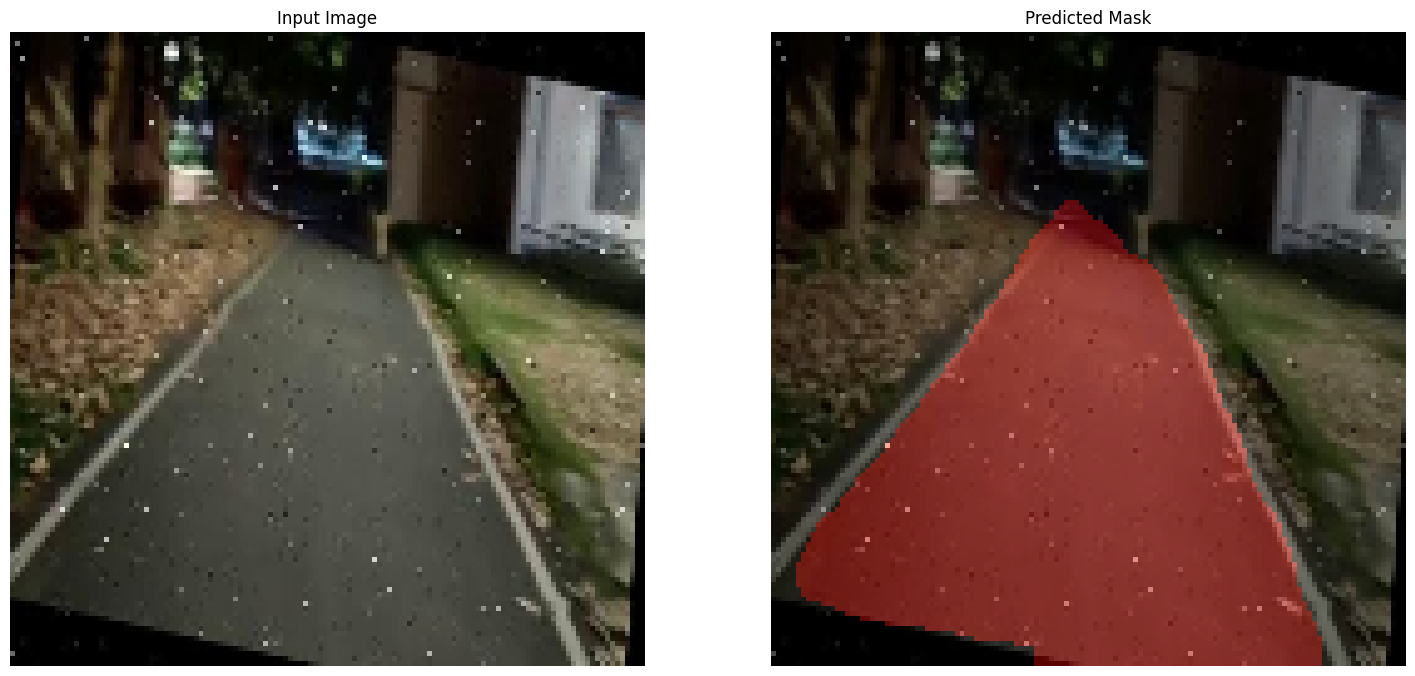

Processing image : 22
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


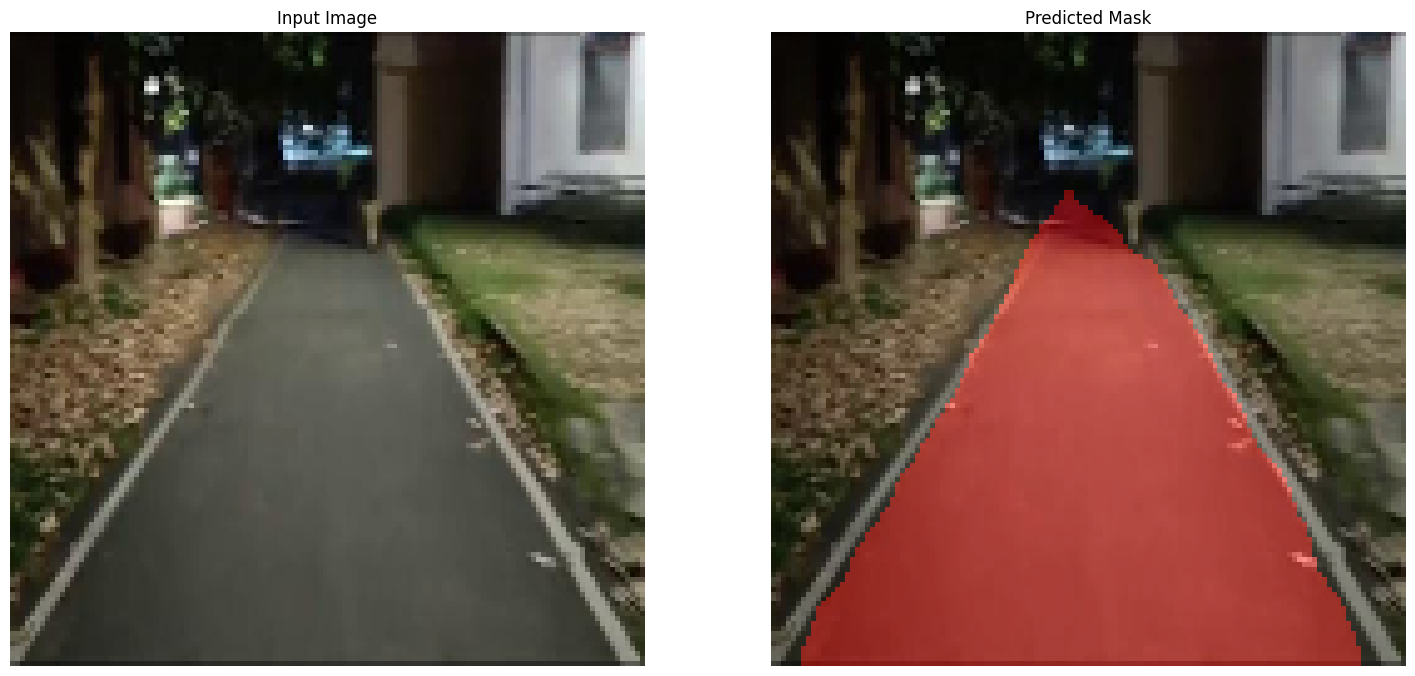

Processing image : 23
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


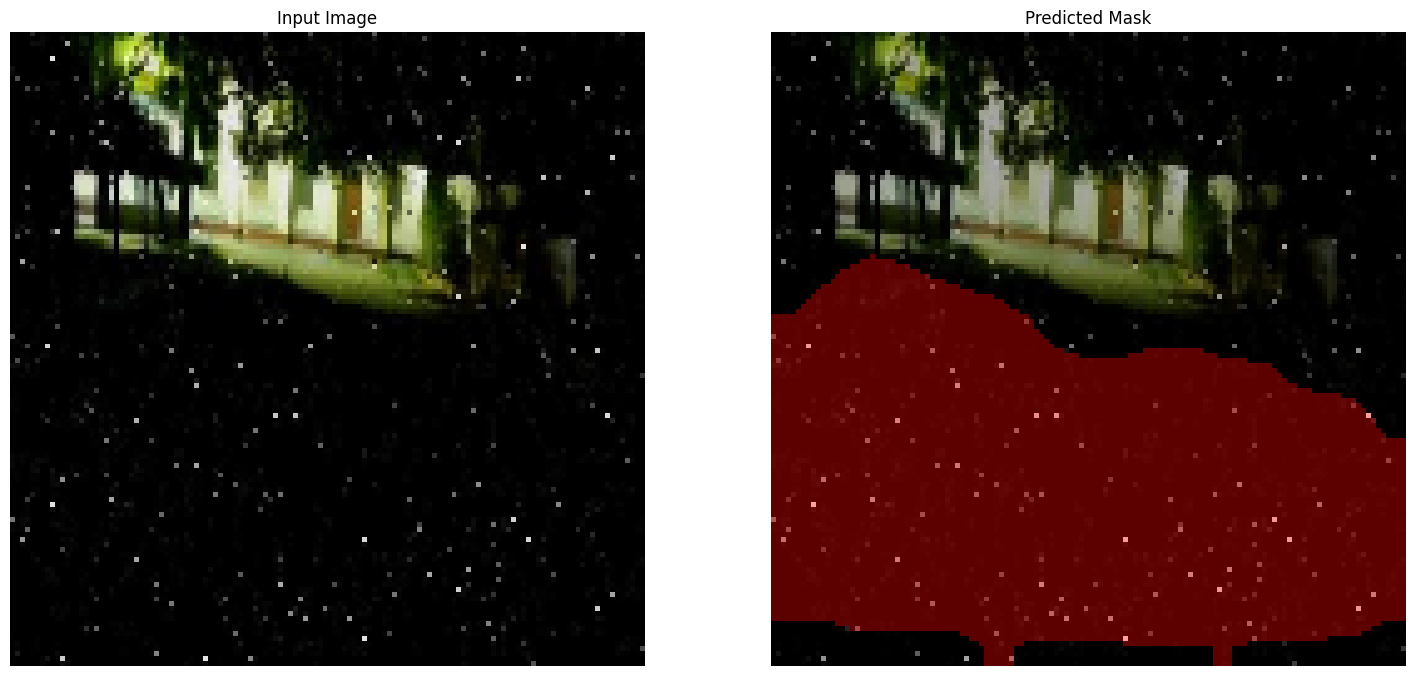

Processing image : 24
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


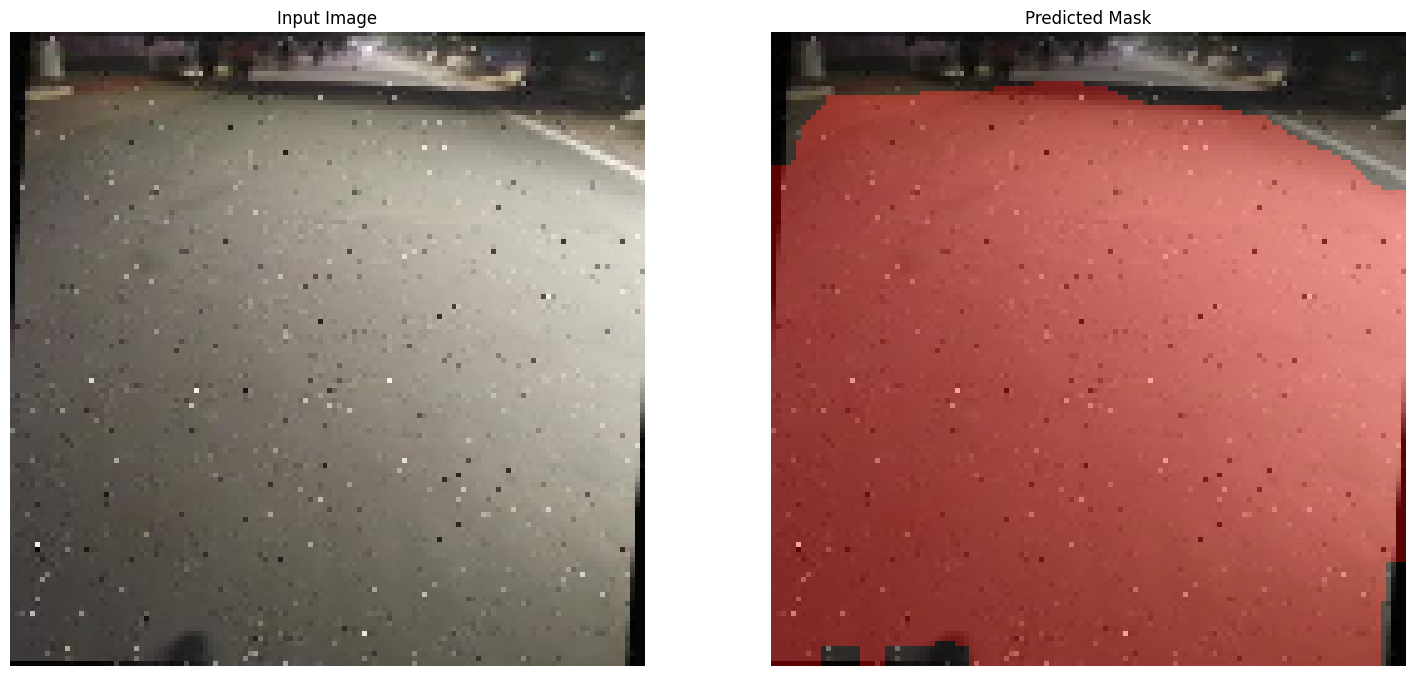

Processing image : 25
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


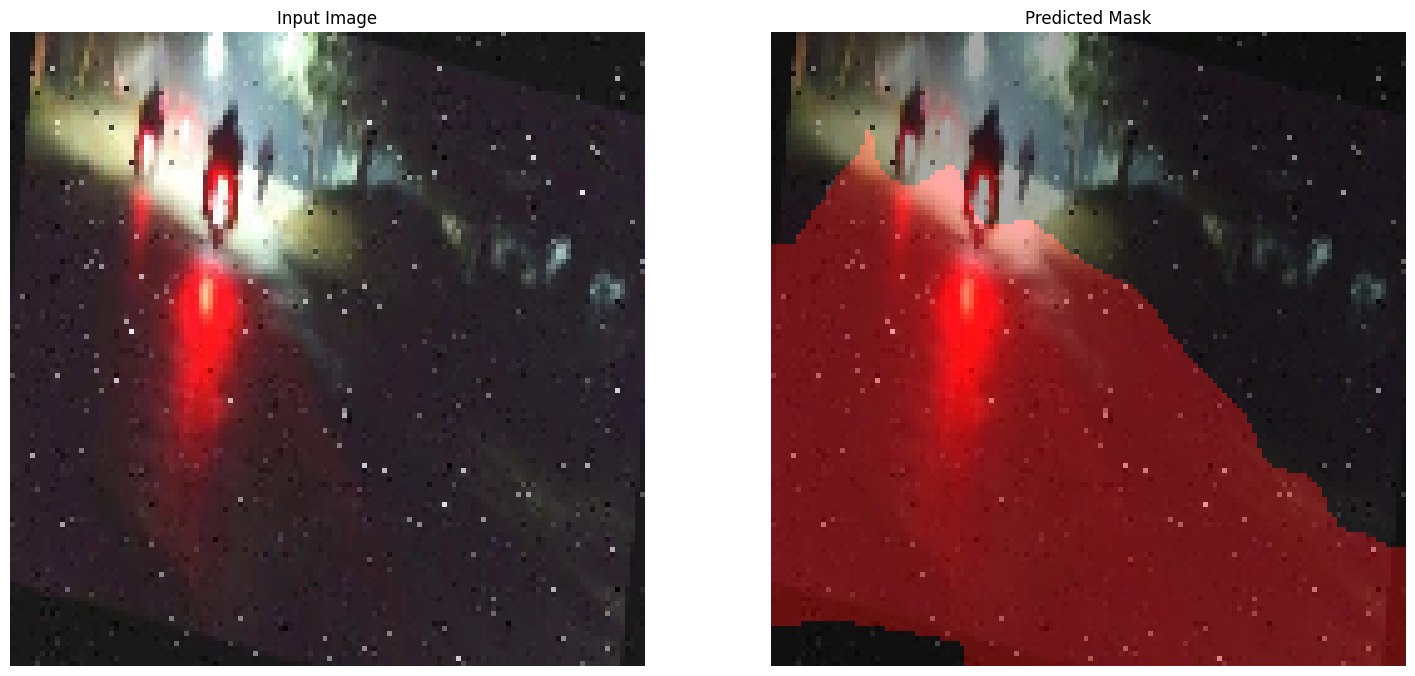

Processing image : 26
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


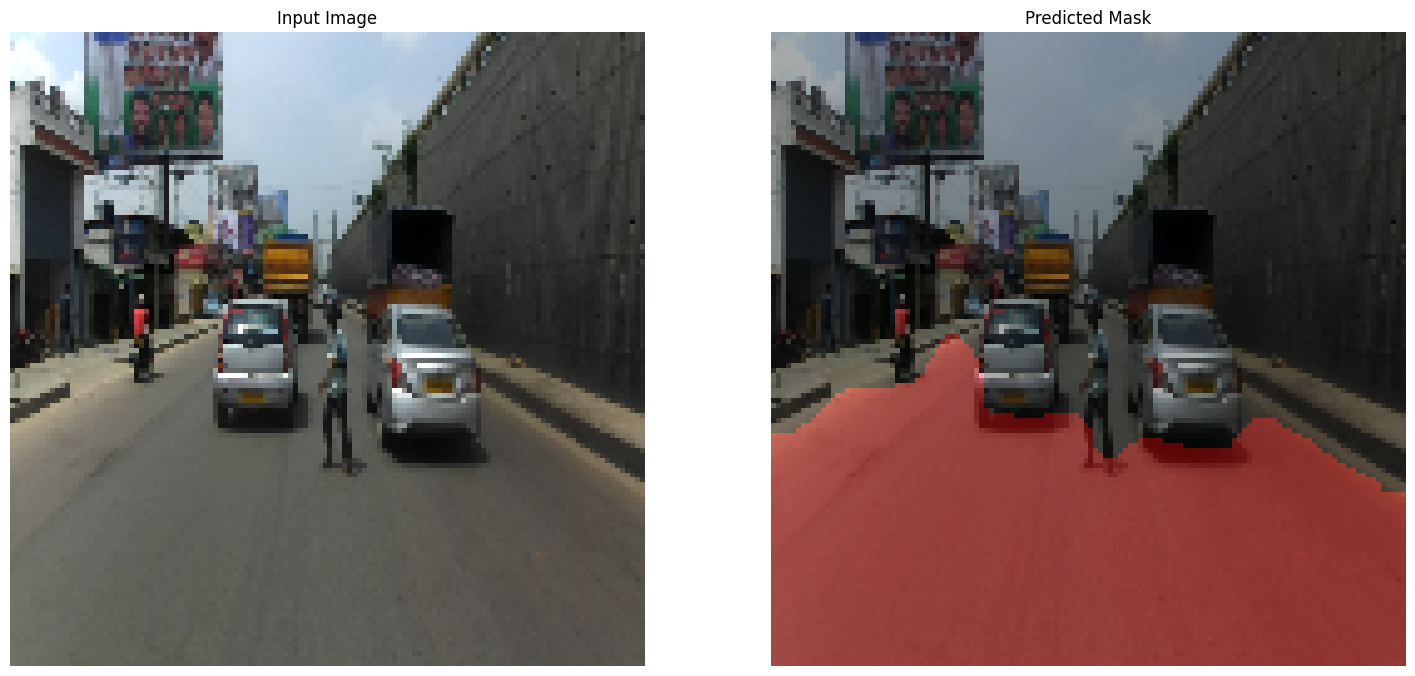

Processing image : 27
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


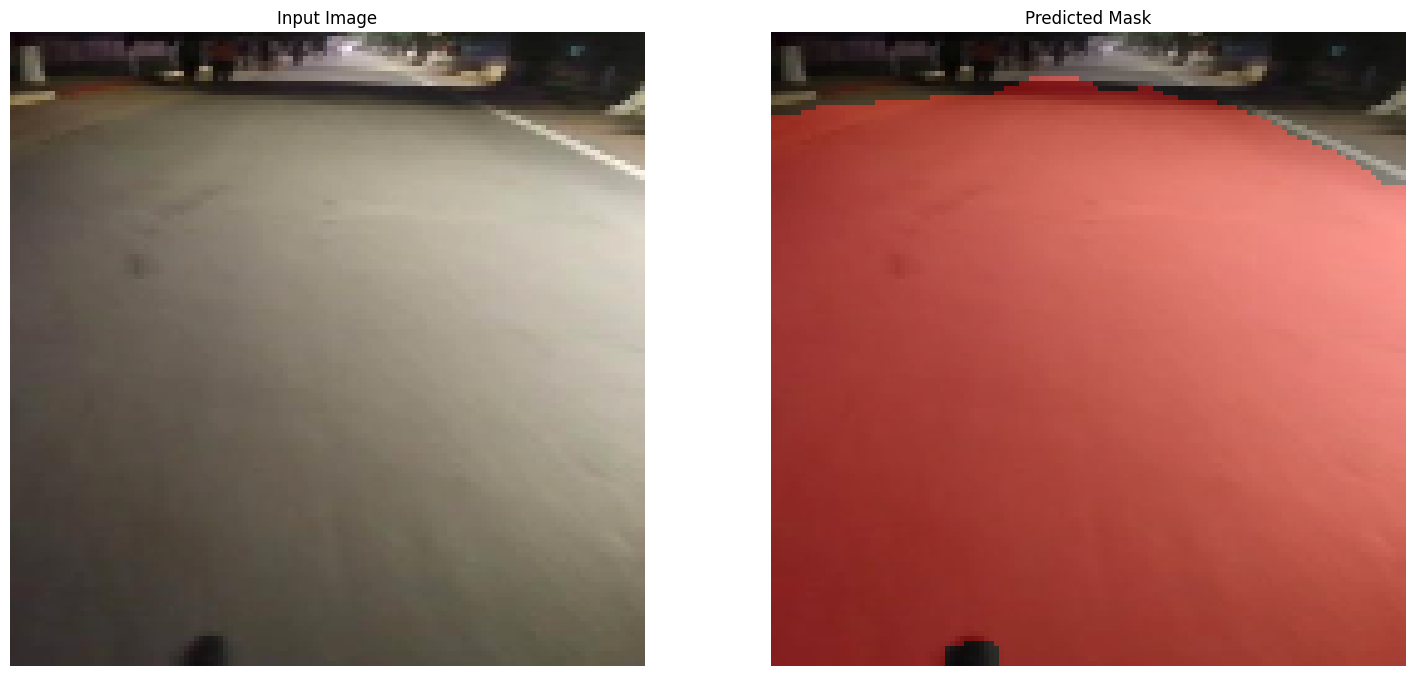

Processing image : 28
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


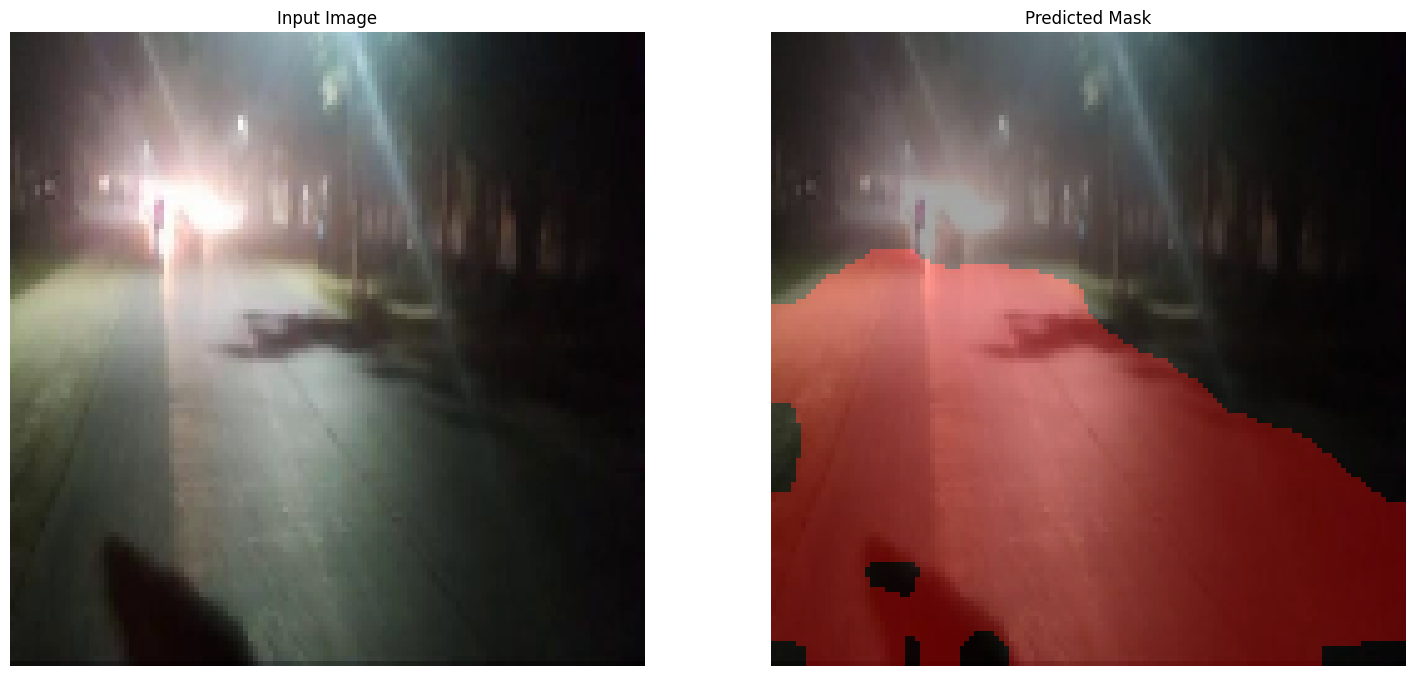

Processing image : 29
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


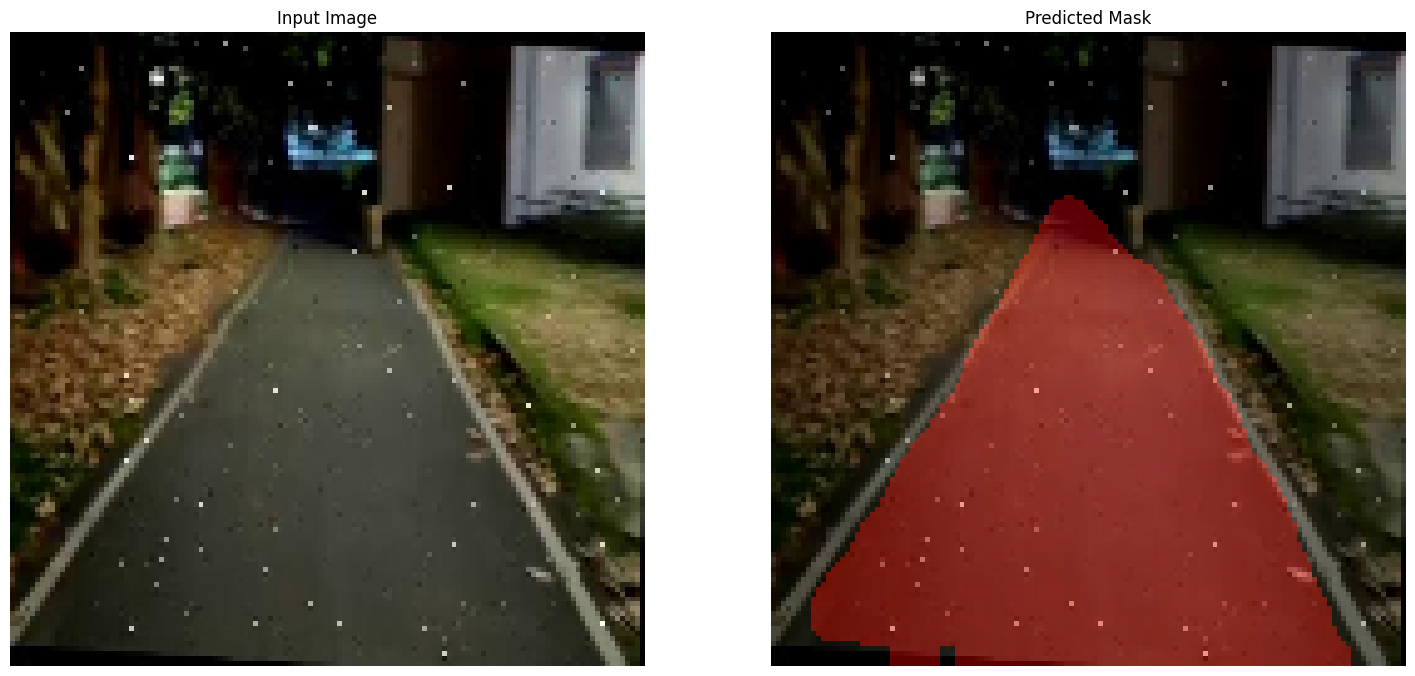

Processing image : 30
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


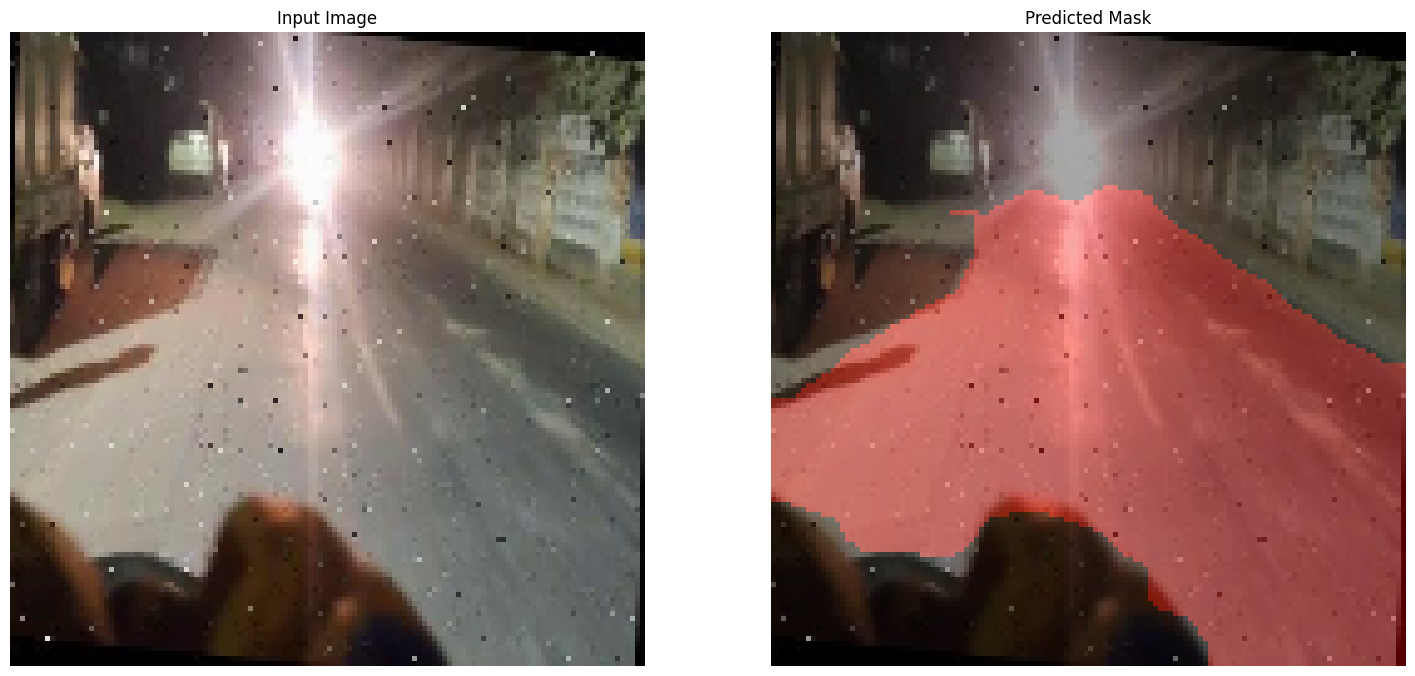

Processing image : 31
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


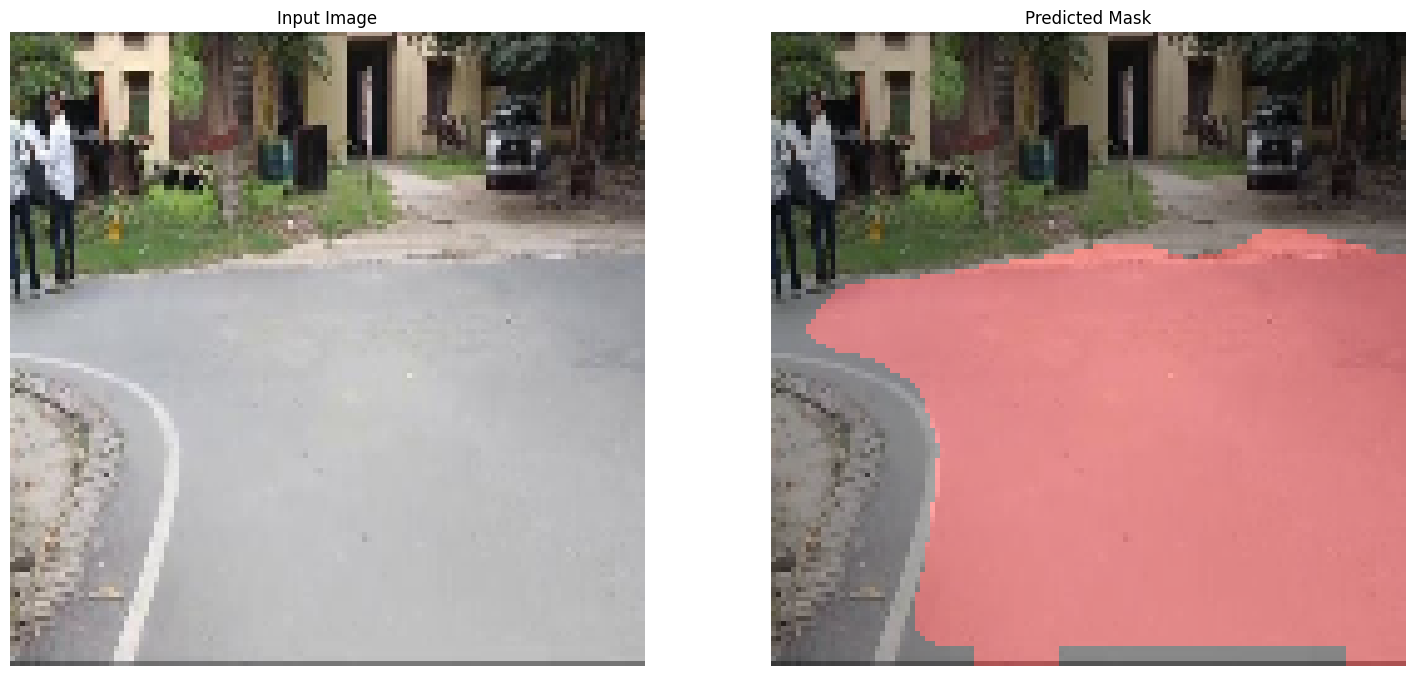

In [ ]:
save_predictions(dataset)